# Model setup and usage 

In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report

from model_helpers import preprocess_data, validate_data, evaluate_model, log_transform, plot_xgb_feature_importance
from setup_model_eval_log import log_model_evaluation

data_location = '../data/raw/psp_raw_data.xlsx'

Validation complete and successful.
None


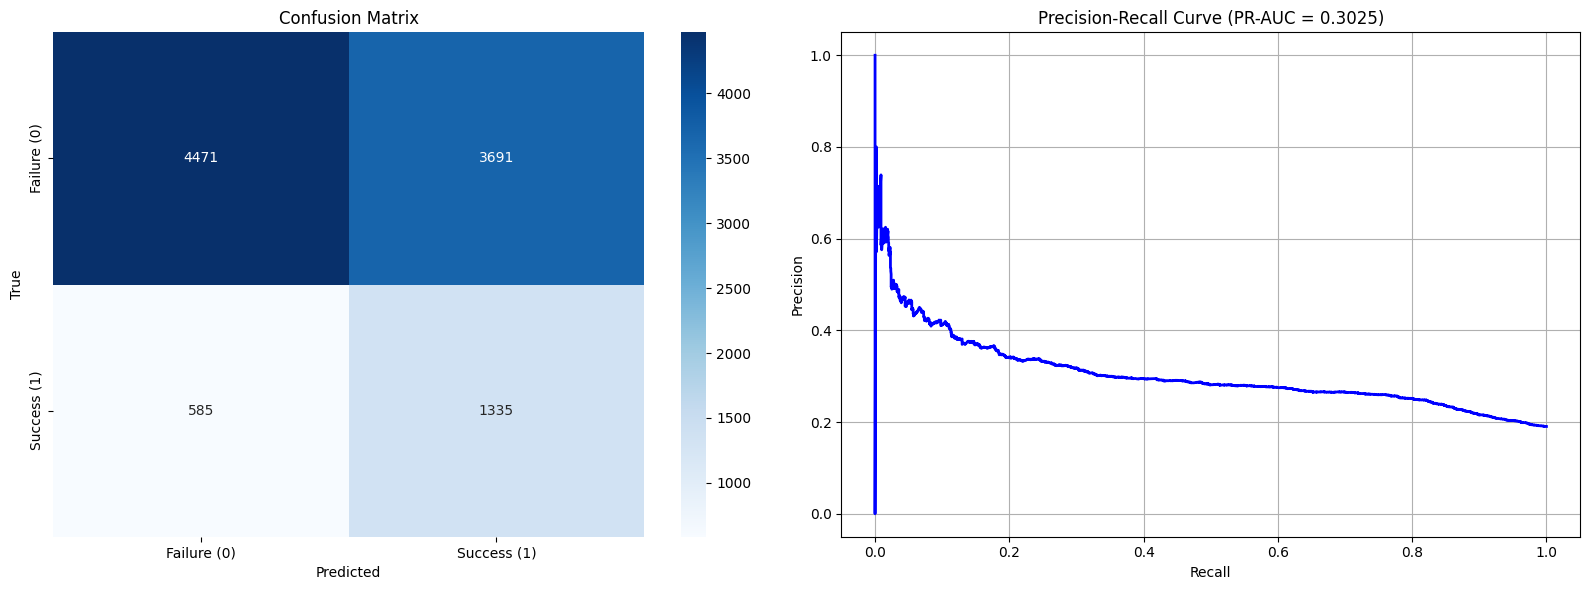


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.884296,0.547782,0.676502,8162.000000
Success (1),0.265619,0.695312,0.384394,1920.000000
accuracy,0.575878,0.575878,0.575878,0.575878
macro avg,0.574957,0.621547,0.530448,10082.000000
weighted avg,0.766476,0.575878,0.620873,10082.000000


Best F1-Score: 0.3877 at Threshold: 0.4906
Total Model F1-Score: 0.3844
Total Model Precision: 0.2656


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd

# Preprocessing function for log transformation
def log_transform(x):
    return np.log1p(x)  # Use log1p to handle zero values safely

# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured']  # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(log_transform, validate=True)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='none'), categorical_features),  # Drop none so we can check the feature importance
        ('binary', 'passthrough', binary_features)
    ]
)

# Updated classifier with best parameters
classifier = XGBClassifier(
    colsample_bytree=0.724478254120072,
    learning_rate=0.005259243138699339,
    max_depth=7,
    min_child_weight=2,
    n_estimators=119,
    scale_pos_weight=3.8541165142031777,
    subsample=0.7212822750999782,
    random_state=42
)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

## Evaluate Model

In [ ]:
evaluate_model(pipeline, X_test, y_test)

## Check Feature Importance

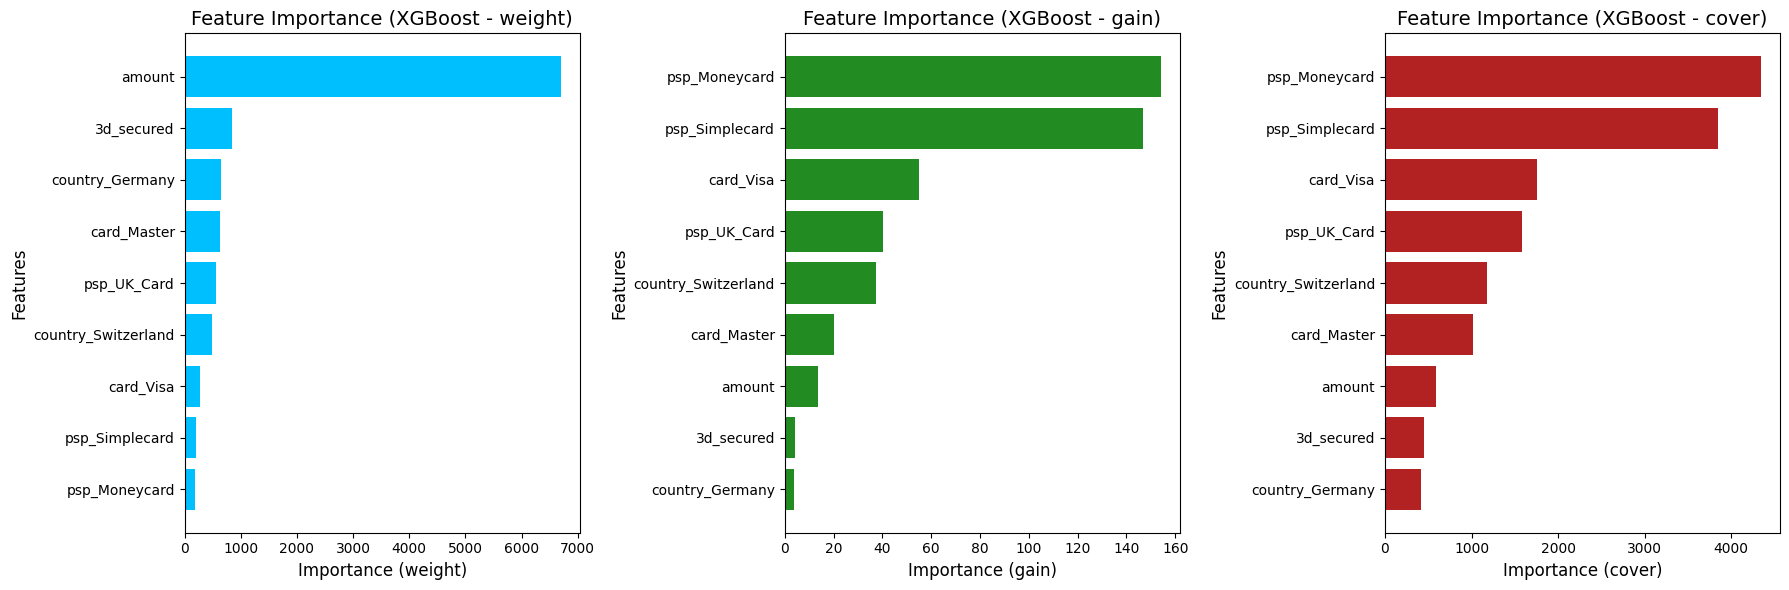

Feature Importance (Weight): {'amount': 6700.0, '3d_secured': 845.0, 'country_Germany': 646.0, 'card_Master': 628.0, 'psp_UK_Card': 557.0, 'country_Switzerland': 484.0, 'card_Visa': 281.0, 'psp_Simplecard': 200.0, 'psp_Moneycard': 192.0}
Feature Importance (Gain): {'psp_Moneycard': 154.1875762939453, 'psp_Simplecard': 146.68223571777344, 'card_Visa': 54.840641021728516, 'psp_UK_Card': 40.21173858642578, 'country_Switzerland': 37.26011276245117, 'card_Master': 20.198001861572266, 'amount': 13.651017189025879, '3d_secured': 4.102435111999512, 'country_Germany': 3.642022132873535}
Feature Importance (Cover): {'psp_Moneycard': 4346.92236328125, 'psp_Simplecard': 3845.411865234375, 'card_Visa': 1753.7364501953125, 'psp_UK_Card': 1577.8955078125, 'country_Switzerland': 1174.3856201171875, 'card_Master': 1018.1331787109375, 'amount': 589.0146484375, '3d_secured': 453.1162414550781, 'country_Germany': 414.1706237792969}


In [4]:
# plot importance scores 
importance_scores = plot_xgb_feature_importance(pipeline, numerical_features, binary_features, categorical_features)

print("Feature Importance (Weight):", importance_scores['weight'])
print("Feature Importance (Gain):", importance_scores['gain'])
print("Feature Importance (Cover):", importance_scores['cover'])

## Pickel final model for usage

In [ ]:
# pickle model 
with open('../models/psp_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)